In [ ]:
# ====================================================================================
# ===============================================                                   ==
# Libraries for dataset verification with DVC. ==                                   ==
# ===============================================                                   ==
from pathlib import Path  # Cross-platform path handling                            ==
from typing import Dict, Tuple, Optional  # Optional type hints for better clarity  ==
import os  # File system and environment variable handling                          ==
import yaml  # Read .dvc (YAML) pointer files                                       ==
import hashlib  # Compute MD5 hashes to verify data integrity                       ==
import subprocess    # Execute SO commands                                          ==
# ====================================================================================

#import de librerias para EDA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import numpy as np

# Import our custom modules
from src import config
from src.data_utils import load_data
from src.plots import (
    plot_target_distribution,
    plot_correlation_matrix,
    create_eda_summary_dashboard,
    plot_categorical_analysis,
    plot_numerical_relationship
)

In [ ]:
# ===============================================================
# DVC dataset verification helpers (MD5 check + pull fallback) ==
# ===============================================================

def ensure_repo_ready(repo_root: str = "/work") -> None:
    """
    Verifies that:
    - `repo_root` is a valid project folder with Git and DVC.
    - Directory `repo_root` exists.
    - It contains a `.git` subdirectory (it's a Git repo).
    - It contains a `.dvc` subdirectory (it's a DVC repo).

    Raises:
    - FileNotFoundError if `repo_root` does not exist.
    - RuntimeError if `.git` or `.dvc` is missing.
    """
    if not os.path.isdir(repo_root):
        raise FileNotFoundError(f"Repo root does not exist: {repo_root}")
    if not os.path.isdir(os.path.join(repo_root, ".git")):
        raise RuntimeError(f"Not a Git repo: {repo_root}")
    if not os.path.isdir(os.path.join(repo_root, ".dvc")):
        raise RuntimeError(f"Not a DVC repo: {repo_root} (.dvc not found)")


def _md5_file(path: str, chunk_size: int = 1024 * 1024) -> str:
    """
    Computes the MD5 hash of a file by streaming it from disk to verify integrity
    against the value stored by DVC in the `.dvc` pointer (default md5-based cache).

    Parameters:
    - path: absolute file path.
    - chunk_size: read block size in bytes (default 1 MB).

    Returns:
    - Hex MD5 string of the file content.
    """
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()


def _read_expected_md5_from_dvc(pointer_path: str) -> Optional[str]:
    """
    Reads the expected MD5 from a single-file `.dvc` pointer.

    `.dvc` format:
      - md5: <hash>
      - hash: md5
      - path: <file_name>

    Parameters:
    - pointer_path: absolute path to the `.dvc` file.

    Returns:
    - The MD5 string if present, or None if the pointer does not exist / lacks md5.

    Use:
    - Compare the expected MD5 from `.dvc` with the actual local file MD5.
    """
    if not os.path.exists(pointer_path):
        return None
    with open(pointer_path, "r", encoding="utf-8") as f:
        data = yaml.safe_load(f) or {}
    outs = data.get("outs") or []
    if not outs:
        return None
    out = outs[0]
    return out.get("md5") or out.get("checksum") or None


def _dvc_pull_target(path_repo_rel: str, repo_root: str = "/work") -> None:
    """
    Runs `dvc pull <path>` or `<path>.dvc` to materialize the correct version from the remote (S3)
    into the local workspace/cache. Raises if it fails (credentials, permissions, etc.).

    Parameters:
    - path_repo_rel: repo-relative path to fetch (e.g., "data/raw/file.csv").
    - repo_root: repo root (e.g., "/work").
    """
# Build possible targets
    dvc_pointer = os.path.join(repo_root, path_repo_rel + ".dvc")
    if os.path.exists(dvc_pointer):
        target = path_repo_rel + ".dvc"
    else:
        target = path_repo_rel

    # Try pulling
    result = subprocess.run(
        ["dvc", "pull", "--quiet", target],
        cwd=repo_root,
        capture_output=True,
        text=True,
    )

    # Raise if failed
    if result.returncode != 0:
        raise RuntimeError(
            f"Failed to run 'dvc pull {target}':\n"
            f"STDOUT:\n{result.stdout}\nSTDERR:\n{result.stderr}"
        )



def dvc_read_csv_verified(
    path_repo_rel: str,
    repo_root: str = "/work",
    prefer_dvc: bool = False,
    verify_local_md5: bool = True,
    pandas_read_csv_kwargs: Optional[Dict] = None,
) -> Tuple[pd.DataFrame, str]:
    """
    Read a DVC-versioned CSV ensuring integrity when reading locally.

    Strategy:
    - If `prefer_dvc=True`: force fetching the official version with `dvc pull`
      and then read locally. Returns ("pulled").
    - If `prefer_dvc=False`:
        1) If the local file exists and `verify_local_md5=True`, compare local MD5
           with the expected MD5 from the `.dvc` pointer.
           * If equal -> read local (fast). Returns ("local").
           * If NOT equal -> run `dvc pull` and read the official version. Returns ("pulled").
        2) If the file does NOT exist -> run `dvc pull` and read the official version. Returns ("pulled").

    Parameters:
    - path_repo_rel: repo-relative CSV path (e.g., "data/raw/file.csv").
    - repo_root: repo root (e.g., "/work").
    - prefer_dvc: if True, ignore local state and fetch official version with `dvc pull`.
    - verify_local_md5: if True, validate local MD5 before trusting local read.
    - pandas_read_csv_kwargs: kwargs for `pandas.read_csv()` (sep, encoding, etc.).

    Returns:
    - (df, source) where source ∈ {"local", "pulled"} describing the read source.

    Exceptions:
    - Raises if the file cannot be materialized from the remote (credentials,
      permissions, or missing blob).
    """
    ensure_repo_ready(repo_root)
    if pandas_read_csv_kwargs is None:
        pandas_read_csv_kwargs = {}

    local_path = os.path.join(repo_root, path_repo_rel)
    dvc_pointer = local_path + ".dvc"  # e.g., data/raw/file.csv.dvc
    expected_md5 = _read_expected_md5_from_dvc(dvc_pointer)

    # Option: force “official” read by fetching from S3
    if prefer_dvc:
        _dvc_pull_target(path_repo_rel, repo_root)
        # Note: when forcing, we don’t compare MD5; we assume `dvc pull` fetched the official version.
        return pd.read_csv(local_path, **pandas_read_csv_kwargs), "pulled"

    # If a local file exists, decide based on MD5
    if os.path.exists(local_path):
        if verify_local_md5 and expected_md5:
            try:
                md5_local = _md5_file(local_path)
                if md5_local == expected_md5:
                    # Note: “MD5 OK: local matches .dvc”
                    # Use the local version (faster) because it’s identical to the “official” one.
                    return pd.read_csv(local_path, **pandas_read_csv_kwargs), "local"
                else:
                    # MD5 differs: local != .dvc → run dvc pull
                    _dvc_pull_target(path_repo_rel, repo_root)
                    return pd.read_csv(local_path, **pandas_read_csv_kwargs), "pulled"
            except Exception:
                # Any issue during the check → ensure consistency with a pull
                _dvc_pull_target(path_repo_rel, repo_root)
                return pd.read_csv(local_path, **pandas_read_csv_kwargs), "pulled"
        else:
            # Local read without MD5 verification
            return pd.read_csv(local_path, **pandas_read_csv_kwargs), "local"

    # If no local file, fetch the official version
    _dvc_pull_target(path_repo_rel, repo_root)
    return pd.read_csv(local_path, **pandas_read_csv_kwargs), "pulled"


In [ ]:
# =======================================
# Configurable dataset read parameters ==
# =======================================

# Docker mounts the project at /work. If your compose changes, adjust REPO_ROOT accordingly.
REPO_ROOT = "/work"  # Where the repo is mounted.
PATH = "data/raw/work_absenteeism_modified.csv"  # Repo-relative path of the DVC-versioned dataset.

# Arguments forwarded to pandas.read_csv. Optional: delimiter, encoding, etc.
READ_KW: Dict = {}  # e.g.: {"sep": ",", "encoding": "utf-8"}

# Read mode:
# - PREFER_DVC=True  -> Force fetching the official version with `dvc pull` and read it.
# - PREFER_DVC=False -> Prefer local only if (and only if) MD5 matches the one in the .dvc.
PREFER_DVC = False
VERIFY_LOCAL_MD5 = True

# =====================================================
# Environment inspection + demo read with MD5 legend ==
# =====================================================
print("Repo root:", REPO_ROOT, "| exists:", Path(REPO_ROOT).exists())
print("Expected CSV:", PATH)

# Show expected MD5 (if the pointer exists)
pointer_path = os.path.join(REPO_ROOT, PATH) + ".dvc"
expected = _read_expected_md5_from_dvc(pointer_path)
print("Expected MD5 (.dvc):", expected or "<no md5 in pointer>")

# If a local file exists, compute local MD5 and compare
local_abs = os.path.join(REPO_ROOT, PATH)
if os.path.exists(local_abs) and expected:
    try:
        local_md5 = _md5_file(local_abs)
        print("Local MD5:", local_md5)
        print("MD5 matches .dvc?", "YES ✅" if local_md5 == expected else "NO ❌")
    except Exception as e:
        print("Could not compute local MD5:", type(e).__name__, str(e)[:120])

# --- Robust read with integrity verification ---
# dvc_read_csv_verified does:
#   1) If PREFER_DVC=True -> run `dvc pull` and read the official version (“pulled”).
#   2) If PREFER_DVC=False:
#        - If the local file exists and VERIFY_LOCAL_MD5=True:
#            compare local MD5 against the MD5 from the .dvc pointer.
#            * If equal -> read local (fast) and consistent.
#            * If different -> `dvc pull` and read the official version.
#        - If the file does not exist locally -> `dvc pull` and read the official version.
df, source = dvc_read_csv_verified(
    PATH,
    repo_root=REPO_ROOT,
    prefer_dvc=PREFER_DVC,
    verify_local_md5=VERIFY_LOCAL_MD5,
    pandas_read_csv_kwargs=READ_KW,
)

print(f"Read from: {source} | rows={len(df)} | cols={len(df.columns)}")


Repo root: /work | exists: True
Expected CSV: data/raw/work_absenteeism_modified.csv
Expected MD5 (.dvc): 96c318341d1846f567be7127f52d03e1
Local MD5: 96c318341d1846f567be7127f52d03e1
MD5 matches .dvc? YES ✅
Read from: local | rows=754 | cols=22


**1. Visualización del dataset**

In [ ]:
absenteeism_df = df
absenteeism_df

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,mixed_type_col
0,11.0,26.0,7.0,3.0,1.0,289.0,36.0,13.0,33.0,239.554,...,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,4.0,535
1,36.0,0.0,7.0,3.0,1.0,118.0,13.0,18.0,50.0,239.554,...,1.0,1.0,1.0,0.0,0.0,98.0,178.0,31.0,0.0,584
2,3.0,23.0,7.0,4.0,1.0,179.0,51.0,18.0,38.0,239.554,...,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,2.0,249
3,7.0,7.0,7.0,5.0,1.0,279.0,5.0,14.0,39.0,239.554,...,1.0,2.0,1.0,1.0,0.0,68.0,168.0,24.0,4.0,538
4,11.0,23.0,7.0,65.0,1.0,289.0,36.0,13.0,33.0,239.554,...,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,2.0,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,22.0,23.0,2.0,3.0,2.0,179.0,26.0,9.0,30.0,302.585,...,3.0,0.0,0.0,0.0,0.0,56.0,171.0,19.0,1.0,156
750,5.0,26.0,12.0,6.0,4.0,235.0,20.0,13.0,43.0,280.549,...,1.0,1.0,1.0,0.0,0.0,106.0,167.0,38.0,8.0,917
751,3.0,23.0,10.0,3.0,4.0,179.0,51.0,18.0,38.0,253.465,...,1.0,0.0,1.0,0.0,0.0,89.0,170.0,NaN,3.0,NaN
752,35.0,0.0,0.0,6.0,3.0,179.0,45.0,14.0,53.0,error,...,1.0,1.0,0.0,0.0,90.0,77.0,175.0,25.0,0.0,293


**1.1 Visualización de las primeras 5 observaciones**

In [ ]:
absenteeism_df.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,mixed_type_col
0,11.0,26.0,7.0,3.0,1.0,289.0,36.0,13.0,33.0,239.554,...,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,4.0,535
1,36.0,0.0,7.0,3.0,1.0,118.0,13.0,18.0,50.0,239.554,...,1.0,1.0,1.0,0.0,0.0,98.0,178.0,31.0,0.0,584
2,3.0,23.0,7.0,4.0,1.0,179.0,51.0,18.0,38.0,239.554,...,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,2.0,249
3,7.0,7.0,7.0,5.0,1.0,279.0,5.0,14.0,39.0,239.554,...,1.0,2.0,1.0,1.0,0.0,68.0,168.0,24.0,4.0,538
4,11.0,23.0,7.0,65.0,1.0,289.0,36.0,13.0,33.0,239.554,...,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,2.0,85


In [ ]:
absenteeism_df.info()

**1.2 Visualización de las últimas 5 observaciones**

In [ ]:
absenteeism_df.tail()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,mixed_type_col
749,22.0,23.0,2.0,3.0,2.0,179.0,26.0,9.0,30.0,302.585,...,3.0,0.0,0.0,0.0,0.0,56.0,171.0,19.0,1.0,156
750,5.0,26.0,12.0,6.0,4.0,235.0,20.0,13.0,43.0,280.549,...,1.0,1.0,1.0,0.0,0.0,106.0,167.0,38.0,8.0,917
751,3.0,23.0,10.0,3.0,4.0,179.0,51.0,18.0,38.0,253.465,...,1.0,0.0,1.0,0.0,0.0,89.0,170.0,NaN,3.0,NaN
752,35.0,0.0,0.0,6.0,3.0,179.0,45.0,14.0,53.0,error,...,1.0,1.0,0.0,0.0,90.0,77.0,175.0,25.0,0.0,293
753,3.0,27.0,2.0,4.0,2.0,179.0,51.0,18.0,38.0,251.818,...,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,3.0,357


**1.3 Dimensión del dataframe**

In [ ]:
absenteeism_df.shape

(754, 22)

**2. Análisis descriptivo (univariante)**

--Objetivo: Entender y describir las caracteristicas de cada una de las variables que conforman el dataset:

In [ ]:
absenteeism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               746 non-null    object 
 1   Reason for absence               748 non-null    object 
 2   Month of absence                 743 non-null    object 
 3   Day of the week                  746 non-null    object 
 4   Seasons                          750 non-null    object 
 5   Transportation expense           746 non-null    object 
 6   Distance from Residence to Work  743 non-null    object 
 7   Service time                     747 non-null    object 
 8   Age                              749 non-null    object 
 9   Work load Average/day            741 non-null    object 
 10  Hit target                       746 non-null    object 
 11  Disciplinary failure             747 non-null    object 
 12  Education             

En el análisis del dataframe de ausentimos observamos que existen 20 columnas de tipo Object, 2 columnas de tipo float64, así como 754 filas. Se puede observar que las 22 columnas de datos, presentan valores faltantes.

**2.1. Análisis de variables categoricas y númericas**

--Objetivo: obtener estádisticas descriptivas categoricas y númericas:

*   Medidas de frecuencia (count, freq)
*   Medidas de diversidad (unique)
*   Medidas de tendencia central (top)


In [ ]:
absenteeism_df.describe(include = object).T

,count,unique,top,freq
ID,746,59,3.0,106
Reason for absence,748,51,23.0,142
Month of absence,743,31,3.0,80
Day of the week,746,21,2.0,151
Seasons,750,17,4.0,191
Transportation expense,746,49,179.0,171
Distance from Residence to Work,743,50,26.0,122
Service time,747,37,18.0,142
Age,749,40,28.0,113
Work load Average/day,741,71,222.196,34


In [ ]:
absenteeism_df.describe().T

Posterior al análisis del dataset se puede mencionar que la razón más frecuente por la que existen asusentimos es por consulta médica.
El mes de marzo es donde ocurren más asentismo; el tiempo de ausentimos habitual es 8hrs, el día en el que existen más ausentismo es el día Lunes y la estación más común es primavera.

Se continua explorando el dataset.

**2.2 Visualización de variables**

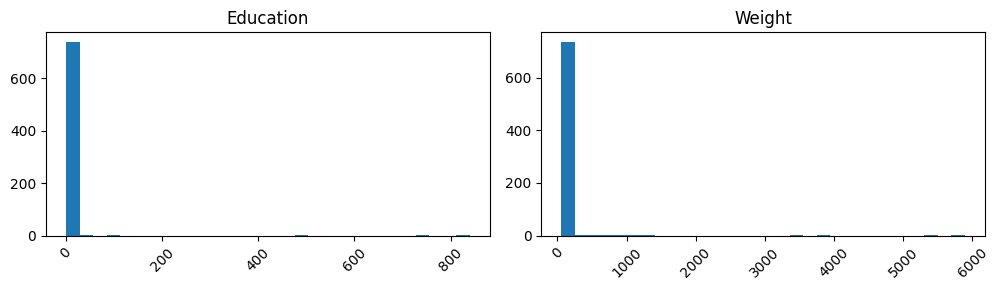

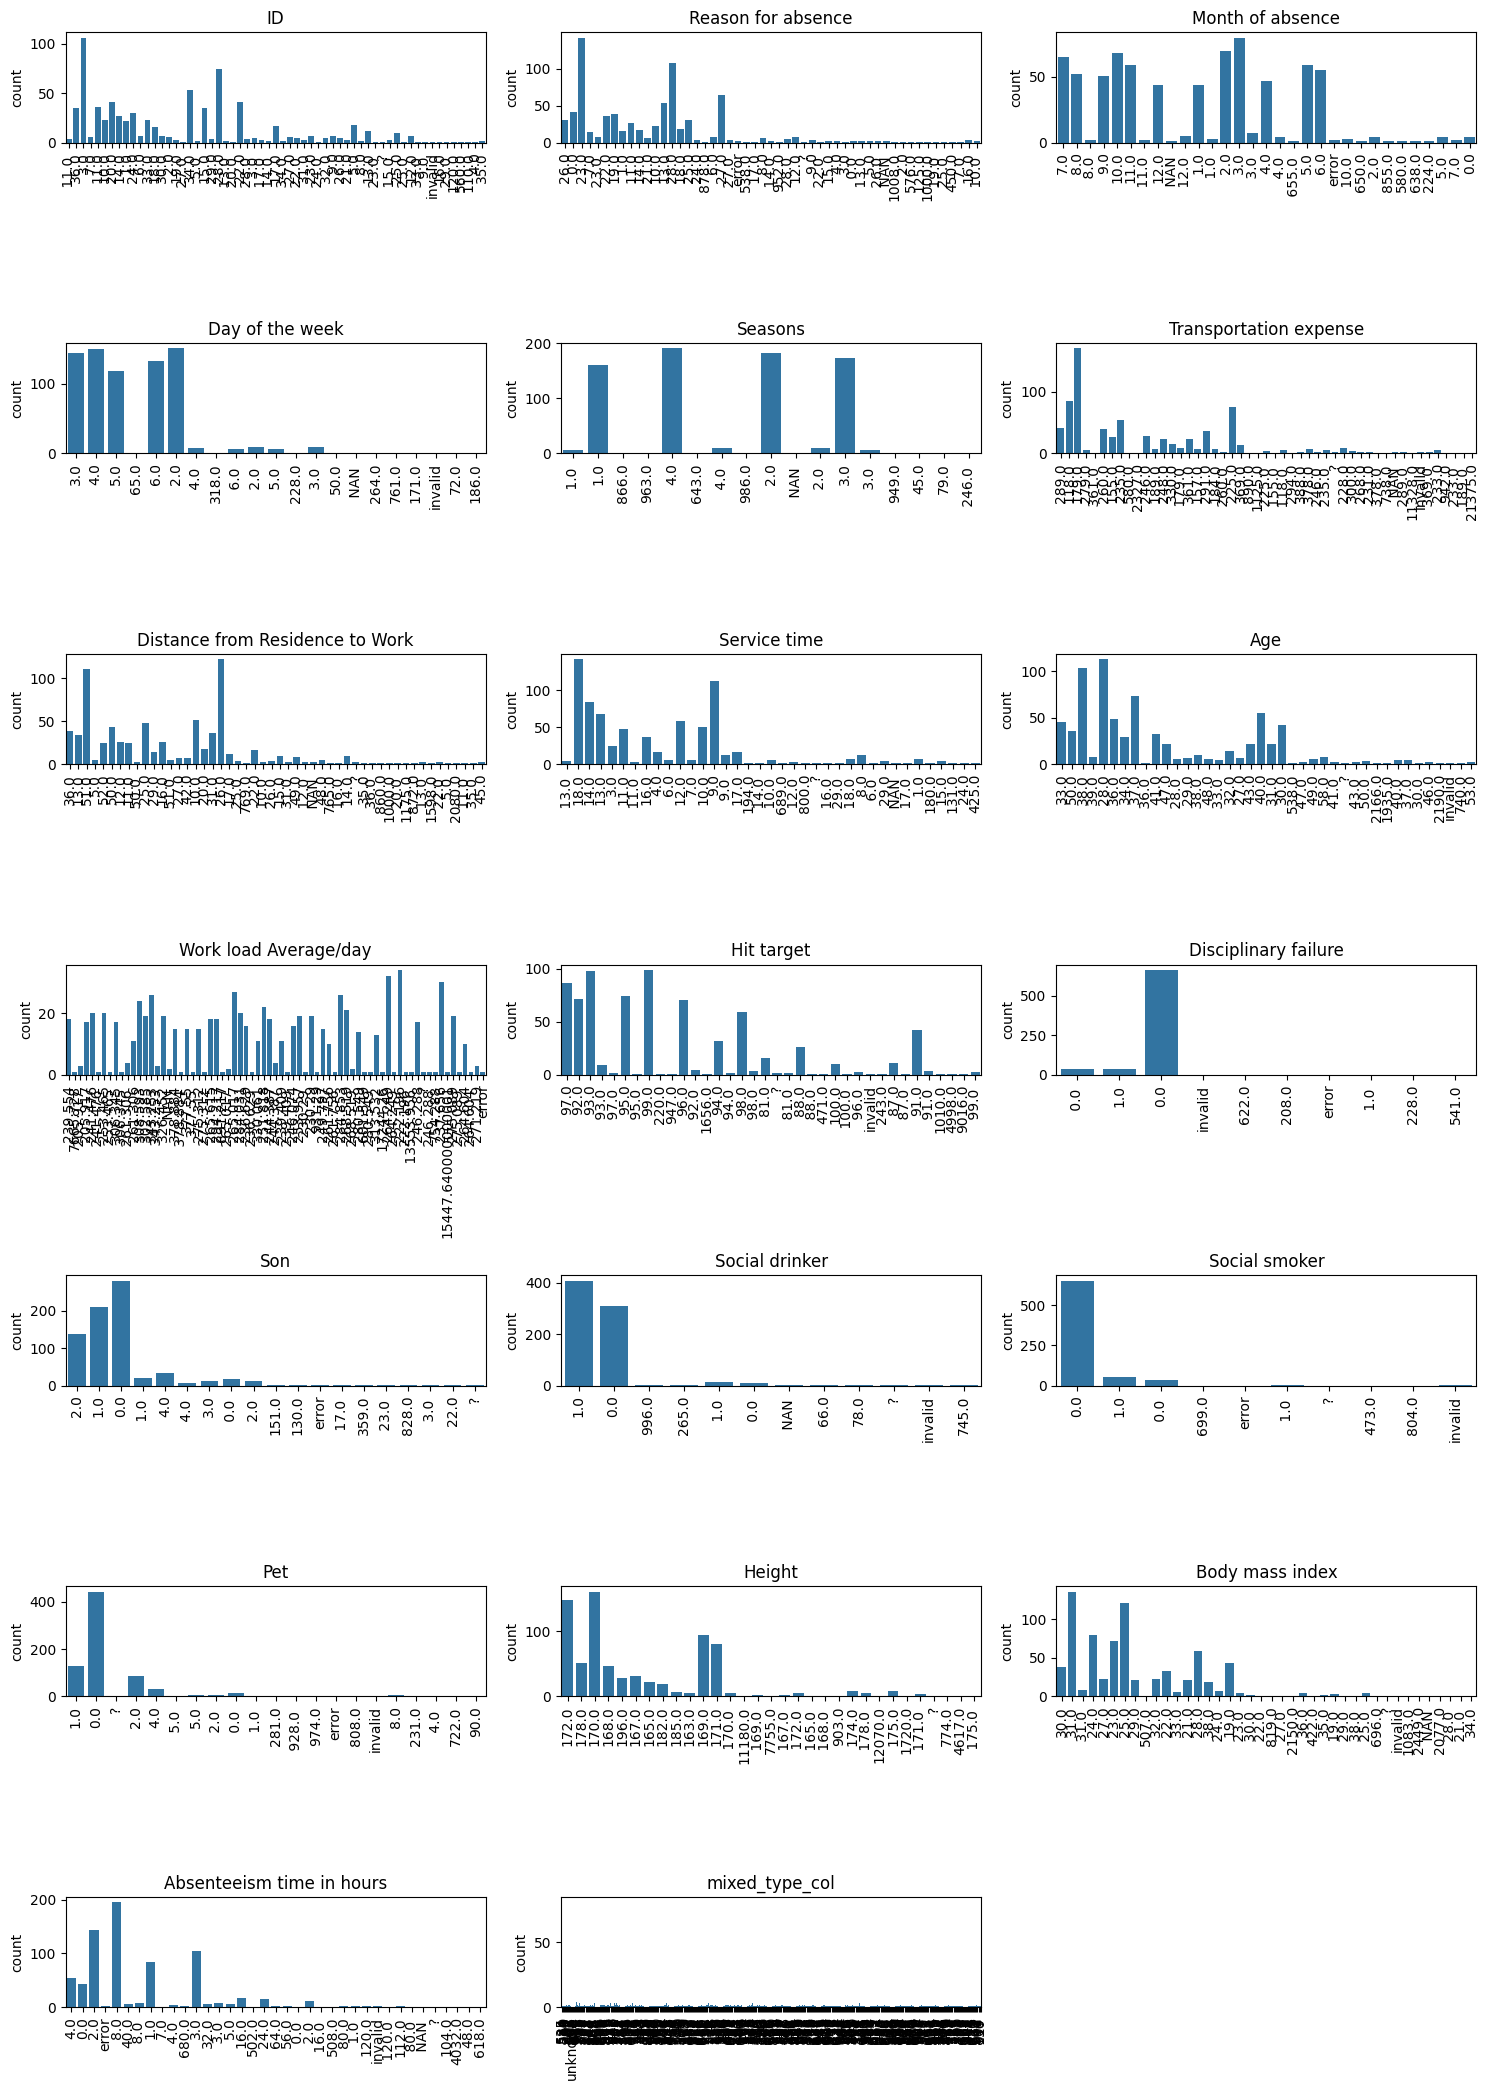

In [ ]:
# Detectar columnas
num_cols = absenteeism_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = absenteeism_df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# ---------- Numéricas ----------
ncols = 3
nrows = max(1, math.ceil(len(num_cols) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3*nrows))
axes = np.array(axes).ravel()  # garantiza 1D aunque nrows=1 o ncols=1

for i, col in enumerate(num_cols):
    ax = axes[i]
    ax.hist(absenteeism_df[col].dropna(), bins=30)
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
# Oculta ejes sobrantes
for j in range(len(num_cols), len(axes)):
    axes[j].set_visible(False)

fig.tight_layout()
plt.show()

# ---------- Categóricas ----------
ncols = 3
nrows = max(1, math.ceil(len(cat_cols) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3*nrows))
axes = np.array(axes).ravel()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(x=absenteeism_df[col], ax=ax)
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('')
for j in range(len(cat_cols), len(axes)):
    axes[j].set_visible(False)

fig.tight_layout()
plt.show()


**2.2.1 Target variable analysis**

In [ ]:
# Target distribution using our custom plot
fig, axes = plot_target_distribution(absenteeism_df, config.TARGET_COLUMN)
plt.show()

# Keep numerical and convert strings to NaN.
absenteeism_df[config.TARGET_COLUMN] = pd.to_numeric(absenteeism_df[config.TARGET_COLUMN], errors="coerce")

# Target statistics
print("\nTarget Variable Statistics:")
print(f"Mean: {absenteeism_df[config.TARGET_COLUMN].mean():.2f} hours")
print(f"Median: {absenteeism_df[config.TARGET_COLUMN].median():.2f} hours")
print(f"Std Dev: {absenteeism_df[config.TARGET_COLUMN].std():.2f} hours")
print(f"Min: {absenteeism_df[config.TARGET_COLUMN].min():.0f} hours")
print(f"Max: {absenteeism_df[config.TARGET_COLUMN].max():.0f} hours")

# Check for outliers
Q1 = absenteeism_df[config.TARGET_COLUMN].quantile(0.25)
Q3 = absenteeism_df[config.TARGET_COLUMN].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(absenteeism_df[config.TARGET_COLUMN] < Q1 - 1.5*IQR) |
              (absenteeism_df[config.TARGET_COLUMN] > Q3 + 1.5*IQR)]
print(f"\nOutliers (IQR method): {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")

**2.2.2 Comprensión EDA dashboard**

In [ ]:
# Create comprehensive EDA dashboard
fig = create_eda_summary_dashboard(absenteeism_df)
plt.show()

print("\n✅ EDA Dashboard created with 7 visualizations")

**2.2.4 Análisis de correlacion**

In [ ]:
# Correlation matrix
fig = plot_correlation_matrix(absenteeism_df, method='pearson')
plt.show()

# Top correlations with target
numeric_df = absenteeism_df.select_dtypes(include=[np.number])
target_corr = numeric_df.corr()[config.TARGET_COLUMN].sort_values(ascending=False)

print("\nTop 10 Correlations with Target:")
print(target_corr.head(11)[1:])  # Exclude self-correlation

**2.2.5 Análisis de feature categoricas**

In [ ]:
# Analyze key categorical features
categorical_features = ['Day of the week', 'Seasons', 'Education']

for feature in categorical_features:
    if feature in absenteeism_df.columns:
        print(f"\n{'='*60}")
        print(f"Analyzing: {feature}")
        print(f"{'='*60}")
        fig = plot_categorical_analysis(absenteeism_df, feature)
        plt.show()

**2.2.6 Análisis de feature númericas**

In [ ]:
# Analyze key numerical features
numerical_features = ['Age', 'Distance from Residence to Work', 'Body mass index']

for feature in numerical_features:
    if feature in absenteeism_df.columns:
        print(f"\n{'='*60}")
        print(f"Analyzing: {feature}")
        print(f"{'='*60}")
        fig = plot_numerical_relationship(absenteeism_df, feature)
        plt.show()

**2.3. Categorías únicas por variable y cantidad de veces que aparecen.**

--Objetivo
- Identificar si existen valores para las variables con formatos diferentes y que representen lo mismo para poder analizar un proceso de limpieza si aplica.

In [ ]:
categorical_cols = absenteeism_df.select_dtypes(include='object').columns

for col in categorical_cols:
    print(f"\n{'='*50}")
    print(f"COLUMNA: {col}")
    print(f"{'='*50}")
    print(absenteeism_df[col].value_counts().head(10))  # Solo top 10


COLUMNA: ID
ID
3.0     106
28.0     74
34.0     53
20.0     41
22.0     41
11.0     36
36.0     35
15.0     35
24.0     30
14.0     27
Name: count, dtype: int64

COLUMNA: Reason for absence
Reason for absence
23.0    142
28.0    108
27.0     64
13.0     53
0.0      42
19.0     38
22.0     36
26.0     31
25.0     30
11.0     26
Name: count, dtype: int64

COLUMNA: Month of absence
Month of absence
3.0     80
2.0     70
10.0    68
7.0     65
11.0    59
5.0     59
6.0     55
8.0     52
9.0     51
4.0     47
Name: count, dtype: int64

COLUMNA: Day of the week
Day of the week
2.0      151
4.0      150
3.0      145
6.0      133
5.0      118
 3.0       9
 2.0       9
 4.0       8
 5.0       6
 6.0       6
Name: count, dtype: int64

COLUMNA: Seasons
Seasons
4.0      191
2.0      183
3.0      173
1.0      160
 2.0      10
 4.0      10
 1.0       7
 3.0       7
963.0      1
986.0      1
Name: count, dtype: int64

COLUMNA: Transportation expense
Transportation expense
179.0    171
118.0     85
22

**2.4. Porcentaje de valores faltantes por columna.**

In [ ]:
absenteeism_df.isna().sum()

ID                                   8
Reason for absence                   6
Month of absence                    11
Day of the week                      8
Seasons                              4
Transportation expense               8
Distance from Residence to Work     11
Service time                         7
Age                                  5
Work load Average/day               13
Hit target                           8
Disciplinary failure                 7
Education                            9
Son                                 12
Social drinker                       5
Social smoker                       10
Pet                                 12
Weight                               6
Height                               5
Body mass index                      4
Absenteeism time in hours           10
mixed_type_col                     106
dtype: int64

**2.5. Identificar porcentaje de valores faltantes para tomar decisiones de limpieza de datos**

In [ ]:
def detectar_valores_invalidos(df):
    """
    Detecta valores faltantes disfrazados y posibles datos inválidos por columna.
    """
    print("Resumen de valores a limpiar:")
    for col in df.columns:
        question_marks = (df[col] == '?').sum()
        errors = (df[col] == 'error').sum()
        unknowns = (df[col] == 'unknown').sum()
        invalid = (df[col] == 'invalid').sum()
        bad = (df[col] == 'bad').sum()
        nan_strings = (df[col].astype(str).str.strip().str.lower() == 'nan').sum()

        # Solo mostrar si hay algo que limpiar
        if any([question_marks, errors, unknowns, invalid, bad, nan_strings]):
            print(f"{col}:")
            if question_marks > 0:
                print(f"  '?' : {question_marks} ({question_marks/len(df)*100:.1f}%)")
            if errors > 0:
                print(f"  'error' : {errors} ({errors/len(df)*100:.1f}%)")
            if invalid > 0:
                print(f"  'invalid' : {invalid} ({invalid/len(df)*100:.1f}%)")
            if unknowns > 0:
                print(f"  'unknown' : {unknowns} ({unknowns/len(df)*100:.1f}%)")
            if bad > 0:
                print(f"  'bad' : {bad} ({bad/len(df)*100:.1f}%)")
            if nan_strings > 0:
                print(f"  'NAN' strings : {nan_strings} ({nan_strings/len(df)*100:.1f}%)")

# Usar la función
detectar_valores_invalidos(absenteeism_df)

Resumen de valores a limpiar:
ID:
  '?' : 1 (0.1%)
  'invalid' : 1 (0.1%)
  'NAN' strings : 8 (1.1%)
Reason for absence:
  '?' : 1 (0.1%)
  'error' : 2 (0.3%)
  'NAN' strings : 8 (1.1%)
Month of absence:
  'error' : 2 (0.3%)
  'NAN' strings : 12 (1.6%)
Day of the week:
  'invalid' : 1 (0.1%)
  'NAN' strings : 9 (1.2%)
Seasons:
  'NAN' strings : 5 (0.7%)
Transportation expense:
  '?' : 2 (0.3%)
  'invalid' : 2 (0.3%)
  'NAN' strings : 10 (1.3%)
Distance from Residence to Work:
  '?' : 2 (0.3%)
  'NAN' strings : 13 (1.7%)
Service time:
  '?' : 1 (0.1%)
  'NAN' strings : 8 (1.1%)
Age:
  '?' : 1 (0.1%)
  'invalid' : 1 (0.1%)
  'NAN' strings : 5 (0.7%)
Work load Average/day:
  '?' : 1 (0.1%)
  'error' : 1 (0.1%)
  'NAN' strings : 15 (2.0%)
Hit target:
  '?' : 2 (0.3%)
  'invalid' : 1 (0.1%)
  'NAN' strings : 8 (1.1%)
Disciplinary failure:
  'error' : 2 (0.3%)
  'invalid' : 1 (0.1%)
  'NAN' strings : 7 (0.9%)
Education:
  'NAN' strings : 9 (1.2%)
Son:
  '?' : 1 (0.1%)
  'error' : 2 (0.3%)
  

**2.6. Identificación de valores duplicados**

In [ ]:
absenteeism_df.duplicated().sum()

np.int64(0)

Según el resultado, no existen valores duplicados.

**2.7. Identificación outliers**

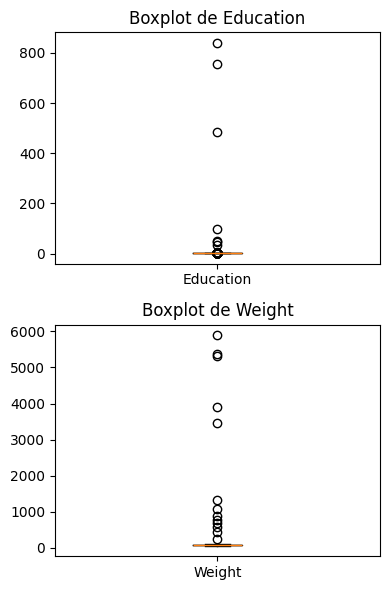

In [ ]:
import matplotlib.pyplot as plt

# Supongamos que float_cols contiene los nombres de las columnas tipo float
float_cols = absenteeism_df.select_dtypes(include='float').columns.tolist()
n = len(float_cols)
fig, axes = plt.subplots(n, 1, figsize=(4, 3 * n))
if n == 1:
    axes = [axes]  # Para el caso de una sola variable

for col, ax in zip(float_cols, axes):
    ax.boxplot(absenteeism_df[col].dropna(), tick_labels=[col])
    ax.set_title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

**3. Limpieza**

Posterior a la exploración de los datos se aplicaran las siguientes actividades de limpieza

**3.1 Eliminar filas con ID faltantes**
- Sin ID válido no se puede relacionar la información.

In [ ]:
# 1. Eliminar filas con ID faltante
absenteeism_df['ID'] = absenteeism_df['ID'].replace('?', np.nan)
absenteeism_df['ID'] = absenteeism_df['ID'].replace('invalid', np.nan)
df_clean= absenteeism_df.dropna(subset=['ID'])

**3.2 Se elimina columna completa: mixed_type_col por falta de información**

In [ ]:
df_clean = df_clean.drop('mixed_type_col', axis=1)

**3.3 Limpieza de caracteres extraños en dataframe y se susutituyen por NAN**

In [ ]:
# Lista de valores a limpiar
valores_invalidos = ['?', 'error', 'invalid', 'unknown', 'bad']
valores_nan_str = ['NAN', 'nan', 'NAN ', ' nan ', ' NAN']
#valores_nan_str = ['NAN']

# Limpiar todas las columnas excepto 'ID' y 'mixed_type_col'
for col in df_clean.columns:
    # Reemplazar todos los valores inválidos y strings 'NAN' por np.nan
    df_clean[col] = df_clean[col].astype(str).str.strip()
    df_clean[col] = df_clean[col].replace(valores_invalidos + valores_nan_str, np.nan)

**4. Imputar valores faltantes según tipo de variable**

Se decició imputar valores faltantes a las siguientes columnas

- Reason for absence
- Month of absence
- Day of the week
- Seasons
- Transportation expense
- Distance from Residence to Work
- Service time
- Age
- Work load Average/day
- Hit target
- Disciplinary failure
- Education
- Son
- Social drinker
- Social smoker
- Pet
- Weight
- Height
- Body mass index
- Absenteeism time in hours

In [ ]:
#Silenciar el warning (más simple)
#import warnings
#warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
# Variables Integer (usar media redondeada)
integer_cols = [
    'Age','Service time','Transportation expense','Distance from Residence to Work',
    'Height','Body mass index','Absenteeism time in hours','Reason for absence',
    'Social drinker','Social smoker','Pet','Weight','Son','Hit target',
    'Month of absence','Day of the week','Seasons','Disciplinary failure','Education'
]
continuous_cols = ['Work load Average/day']

# Limita a las que existen en el DF
int_present = [c for c in integer_cols if c in df_clean.columns]
cont_present = [c for c in continuous_cols if c in df_clean.columns]

# --- Enteras: media redondeada y casteo a Int64 (nullable) ---
for col in int_present:
    s = pd.to_numeric(df_clean[col], errors='coerce')           # garantiza numérico
    mean_val = int(round(s.mean())) if s.notna().any() else 0   # fallback si todo es NaN
    s = s.fillna(mean_val).astype('Int64')                      # evita el FutureWarning
    df_clean[col] = s

# --- Continuas: mediana y casteo explícito a float ---
for col in cont_present:
    s = pd.to_numeric(df_clean[col], errors='coerce').astype(float)
    median_val = s.median() if s.notna().any() else 0.0
    s = s.fillna(median_val)                                    # ya es float -> sin warning
    df_clean[col] = s

Se visualiza dataset y se puede percibir que ya no existen valores faltantes

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 744 entries, 0 to 753
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               744 non-null    object 
 1   Reason for absence               744 non-null    Int64  
 2   Month of absence                 744 non-null    Int64  
 3   Day of the week                  744 non-null    Int64  
 4   Seasons                          744 non-null    Int64  
 5   Transportation expense           744 non-null    Int64  
 6   Distance from Residence to Work  744 non-null    Int64  
 7   Service time                     744 non-null    Int64  
 8   Age                              744 non-null    Int64  
 9   Work load Average/day            744 non-null    float64
 10  Hit target                       744 non-null    Int64  
 11  Disciplinary failure             744 non-null    Int64  
 12  Education                  

**5. Asignar tipo de datos**

In [ ]:
integer_cols_type ={'Age':int, 'Service time':int, 'Transportation expense':int,
                'Distance from Residence to Work':int, 'Height':int,
                'Body mass index':int, 'Absenteeism time in hours':int,
                'Reason for absence':int, 'Social drinker':int, 'Social smoker':int,
                'Pet':int,'Weight':int,'Son':int,'Hit target':int,'Month of absence':int,'Day of the week':int,
                'Seasons':int,'Disciplinary failure':int,'Education':int}

continuous_cols_type = {'Work load Average/day':float}

df_clean = df_clean.astype(integer_cols_type)
df_clean = df_clean.astype(continuous_cols_type)

**6. Visualización de dataframe limpio y sin valores faltantes**

In [ ]:
df_clean.isna().sum()

ID                                 0
Reason for absence                 0
Month of absence                   0
Day of the week                    0
Seasons                            0
Transportation expense             0
Distance from Residence to Work    0
Service time                       0
Age                                0
Work load Average/day              0
Hit target                         0
Disciplinary failure               0
Education                          0
Son                                0
Social drinker                     0
Social smoker                      0
Pet                                0
Weight                             0
Height                             0
Body mass index                    0
Absenteeism time in hours          0
dtype: int64

**6.1 Se exporta dataframe limpio a .csv**

In [ ]:
df_clean.to_csv("/work/data/processed/absenteeism_cleaned.csv", index=False)